In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import ta  # Technical Analysis library
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random
import matplotlib.pyplot as plt


In [4]:
# Download data
START_DATE = '2010-01-01'
END_DATE = '2020-12-31'
STOCKS = ['AAPL','TSLA', 'AMZN', 'GOOGL', 'MSFT', 'META','NVDA']

def download_data(tickers, start, end):
    data = {}
    for ticker in tickers:
        df = yf.download(ticker, start=start, end=end)
        df = df.dropna()
        data[ticker] = df
    return data

data = download_data(STOCKS, START_DATE, END_DATE)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
# Add technical indicators
def add_technical_indicators(df):
    close = df['Close']
    
    # Ensure 'close' is a Series
    if isinstance(close, pd.DataFrame):
        close = close.squeeze()
    
    # Ensure 'close' is 1D
    if len(close.shape) > 1:
        close = close.flatten()
    
    # Compute indicators
    df['MA50'] = ta.trend.sma_indicator(close, window=50)
    df['MA200'] = ta.trend.sma_indicator(close, window=200)
    df['RSI'] = ta.momentum.RSIIndicator(close, window=14).rsi()
    df['MACD'] = ta.trend.MACD(close).macd()
    
    df = df.dropna()
    return df

for ticker in STOCKS:
    data[ticker] = add_technical_indicators(data[ticker])
    
print(data)    

{'AAPL': Price        Adj Close       Close        High         Low        Open  \
Ticker            AAPL        AAPL        AAPL        AAPL        AAPL   
Date                                                                     
2010-10-18    9.580285   11.357143   11.392857   11.224643   11.373929   
2010-10-19    9.323909   11.053214   11.206071   10.715000   10.835714   
2010-10-20    9.355245   11.090357   11.223214   10.959643   11.035714   
2010-10-21    9.324810   11.054286   11.240714   10.957143   11.155714   
2010-10-22    9.263053   10.981071   11.072857   10.939286   11.038214   
...                ...         ...         ...         ...         ...   
2020-12-23  128.059875  130.960007  132.429993  130.779999  132.160004   
2020-12-24  129.047546  131.970001  133.460007  131.100006  131.320007   
2020-12-28  133.663040  136.690002  137.339996  133.509995  133.990005   
2020-12-29  131.883316  134.869995  138.789993  134.339996  138.050003   
2020-12-30  130.758774  133.7

In [6]:
class TradingEnv(gym.Env):
    def __init__(self, df, initial_balance=100000, window_size=60):
        super(TradingEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.window_size = window_size
        self.current_step = 0
        self.balance = initial_balance
        self.net_worth = initial_balance
        self.shares_held = 0
        self.max_steps = len(self.df) - window_size
    
        # Actions: 0 = Hold, 1 = Buy, 2 = Sell
        self.action_space = spaces.Discrete(3)
    
        # Observation space
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(window_size, len(self.df.columns)),
            dtype=np.float32
        )

    def reset(self):
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.shares_held = 0
        self.current_step = 0
        return self._next_observation()

    def _next_observation(self):
        frame = self.df.iloc[self.current_step:self.current_step + self.window_size]
        obs = frame.values
        return obs.astype(np.float32)

    def step(self, action):
        
        # Ensure current_price is a scalar float
        current_price = float(self.df.iloc[self.current_step + self.window_size - 1]['Close'])
        done = False

        # Execute action
        if action == 1:  # Buy
            shares_to_buy = self.balance // current_price
            if shares_to_buy > 0:
                self.balance -= shares_to_buy * current_price
                self.shares_held += shares_to_buy
        elif action == 2:  # Sell
            if self.shares_held > 0:
                self.balance += self.shares_held * current_price
                self.shares_held = 0

        # Move to next timestep
        self.current_step += 1

        # Calculate net worth
        self.net_worth = self.balance + self.shares_held * current_price

        # Calculate reward as the change in net worth
        reward = self.net_worth - self.initial_balance

        if self.current_step >= self.max_steps:
            done = True

        obs = self._next_observation()
        return obs, reward, done, {}


    def render(self, mode='human'):
        profit = self.net_worth - self.initial_balance
        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance}')
        print(f'Shares held: {self.shares_held}')
        print(f'Net worth: {self.net_worth}')
        print(f'Profit: {profit}')

In [7]:
class DeepQNet(nn.Module):
    def __init__(self, input_dim, num_hidden_layers=2, hidden_dim=64, output_dim=3):
        super(DeepQNet, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())

        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


In [8]:
class DQNAgent:
    def __init__(self, state_size, action_size, hidden_dim=64, learning_rate=1e-3, gamma=0.95, device='cpu'):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.device = torch.device(device)

        # Q-Network and Target Network
        self.q_network = DeepQNet(input_dim=state_size, hidden_dim=hidden_dim, output_dim=action_size).to(self.device)
        self.target_network = DeepQNet(input_dim=state_size, hidden_dim=hidden_dim, output_dim=action_size).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        # Optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)

        # Replay Memory
        self.memory = deque(maxlen=100000)

        # Exploration parameters
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

    def remember(self, state, action, reward, next_state, done):
        state = torch.FloatTensor(state).to(self.device)
        next_state = torch.FloatTensor(next_state).to(self.device)
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            act_values = self.q_network(state)
        return torch.argmax(act_values[0]).item()

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return None
        minibatch = random.sample(self.memory, batch_size)
        states = torch.stack([s[0] for s in minibatch]).to(self.device)
        actions = torch.LongTensor([s[1] for s in minibatch]).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor([s[2] for s in minibatch]).unsqueeze(1).to(self.device)
        next_states = torch.stack([s[3] for s in minibatch]).to(self.device)
        dones = torch.FloatTensor([s[4] for s in minibatch]).unsqueeze(1).to(self.device)

        # Current Q values
        q_values = self.q_network(states).gather(1, actions)

        # Target Q values
        with torch.no_grad():
            max_next_q_values = self.target_network(next_states).max(1)[0].unsqueeze(1)
            target_q_values = rewards + (self.gamma * max_next_q_values * (1 - dones))

        # Compute loss
        loss = F.mse_loss(q_values, target_q_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss.item()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

In [9]:
def train_dqn_agent(env, agent, num_episodes=100, batch_size=64, target_update_freq=10):
    rewards_history = []
    losses = []

    for e in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            # Flatten the observation
            state_flat = state.flatten()
            # Select action
            action = agent.act(state_flat)
            # Execute action
            next_state, reward, done, _ = env.step(action)
            next_state_flat = next_state.flatten()
            # Store experience
            agent.remember(state_flat, action, reward, next_state_flat, done)
            # Update state
            state = next_state
            total_reward += reward
            # Replay and train
            loss = agent.replay(batch_size)
            if loss is not None:
                losses.append(loss)

        rewards_history.append(total_reward)
        print(f"Episode {e+1}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")

        # Update target network
        if e % target_update_freq == 0:
            agent.update_target_network()

    return rewards_history, losses


In [10]:
def plot_training_metrics(rewards, losses):
    plt.figure(figsize=(12,5))

    # Plot Rewards
    plt.subplot(1,2,1)
    plt.plot(rewards, label='Total Reward per Episode')
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title('DQN Training Rewards')
    plt.legend()

    # Plot Losses
    plt.subplot(1,2,2)
    plt.plot(losses, label='Loss per Training Step')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('DQN Training Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [12]:
data = download_data(STOCKS, START_DATE, END_DATE)
TRAIN_TEST_SPLIT = 0.8
for ticker in STOCKS:
    data[ticker] = add_technical_indicators(data[ticker])

train_data = {}
test_data = {}
for ticker in STOCKS:
    df = data[ticker]
    split_idx = int(len(df) * TRAIN_TEST_SPLIT)
    train_data[ticker] = df[:split_idx]
    test_data[ticker] = df[split_idx:]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Training DQN agent for AAPL


C:\Users\yang1\AppData\Local\Temp\ipykernel_31716\3815120191.py:39: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(self.df.iloc[self.current_step + self.window_size - 1]['Close'])


Episode 1/100, Total Reward: 25040943.631788254, Epsilon: 0.01
Episode 2/100, Total Reward: 141708263.9811554, Epsilon: 0.01
Episode 3/100, Total Reward: 149556701.58569145, Epsilon: 0.01
Episode 4/100, Total Reward: 218402127.1263399, Epsilon: 0.01
Episode 5/100, Total Reward: 31243297.05487156, Epsilon: 0.01
Episode 6/100, Total Reward: 75622716.2794981, Epsilon: 0.01
Episode 7/100, Total Reward: 144372852.6126089, Epsilon: 0.01
Episode 8/100, Total Reward: 52509038.03763962, Epsilon: 0.01
Episode 9/100, Total Reward: 56675751.10742283, Epsilon: 0.01
Episode 10/100, Total Reward: 21282881.50567341, Epsilon: 0.01
Episode 11/100, Total Reward: 42153218.06194019, Epsilon: 0.01
Episode 12/100, Total Reward: 77003570.34936428, Epsilon: 0.01
Episode 13/100, Total Reward: 132035011.72472382, Epsilon: 0.01
Episode 14/100, Total Reward: 106397473.35442734, Epsilon: 0.01
Episode 15/100, Total Reward: 140970761.3992157, Epsilon: 0.01
Episode 16/100, Total Reward: 145396380.7275858, Epsilon: 0.0

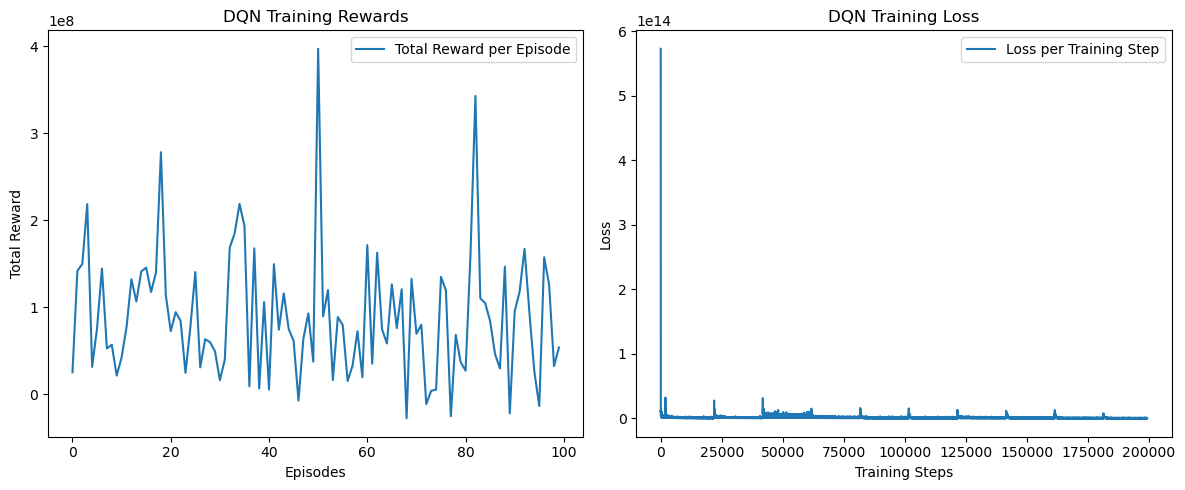

C:\Users\yang1\AppData\Local\Temp\ipykernel_31716\2394355548.py:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(env.df.iloc[env.current_step + env.window_size - 1]['Close'])


Test completed. Total Reward: 30698182.69217682


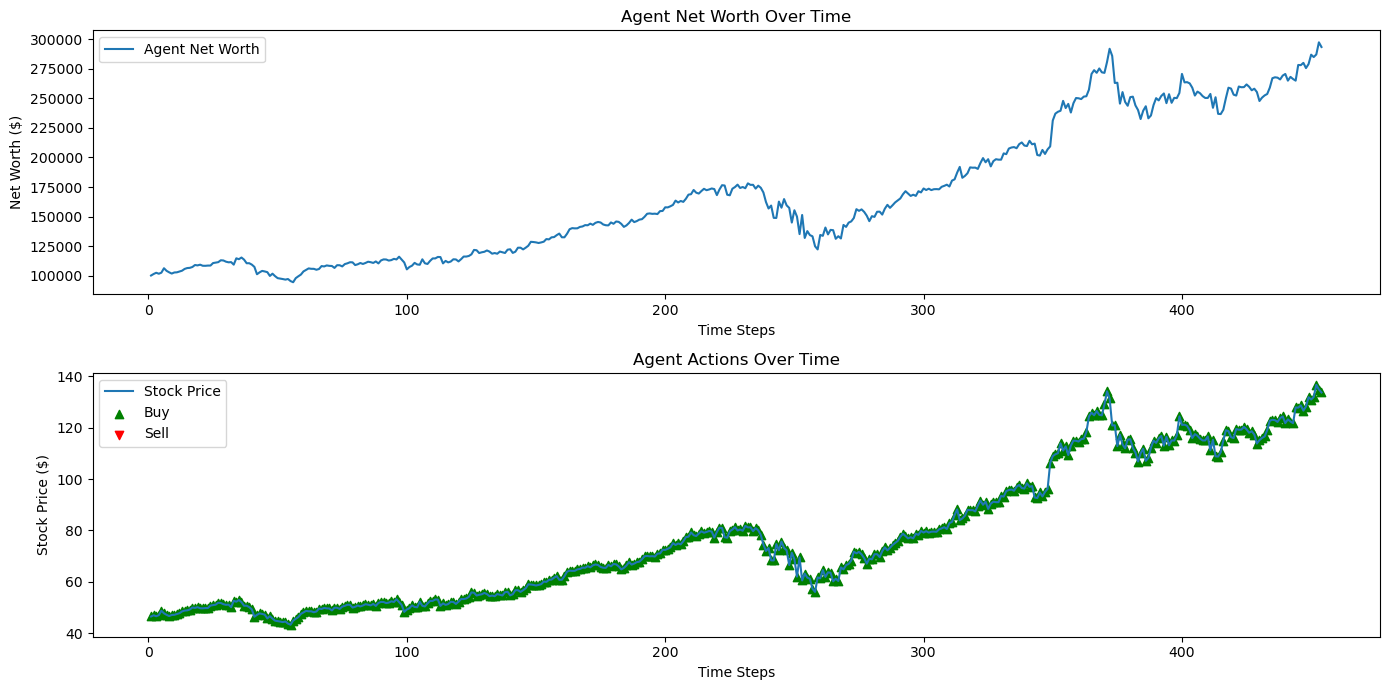

Total Return: 193.62%
Annualized Return: 107.47%
Sharpe Ratio: 1.76
Maximum Drawdown: 59.52%


C:\Users\yang1\AppData\Local\Temp\ipykernel_31716\2354030575.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  initial_price = float(env.df.iloc[env.window_size - 1]['Close'])


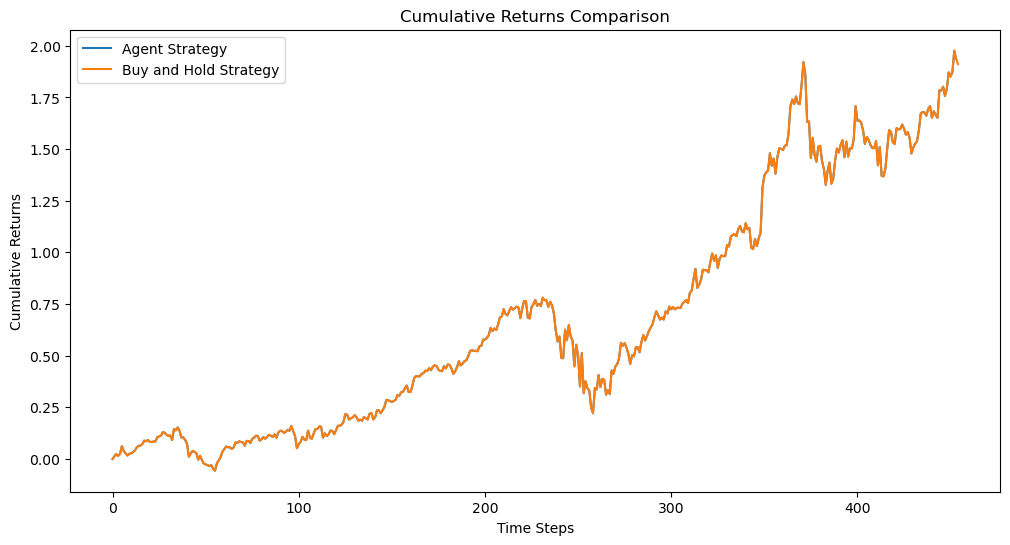

C:\Users\yang1\AppData\Local\Temp\ipykernel_31716\296592116.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(env.df.iloc[current_step - 1]['Close'])


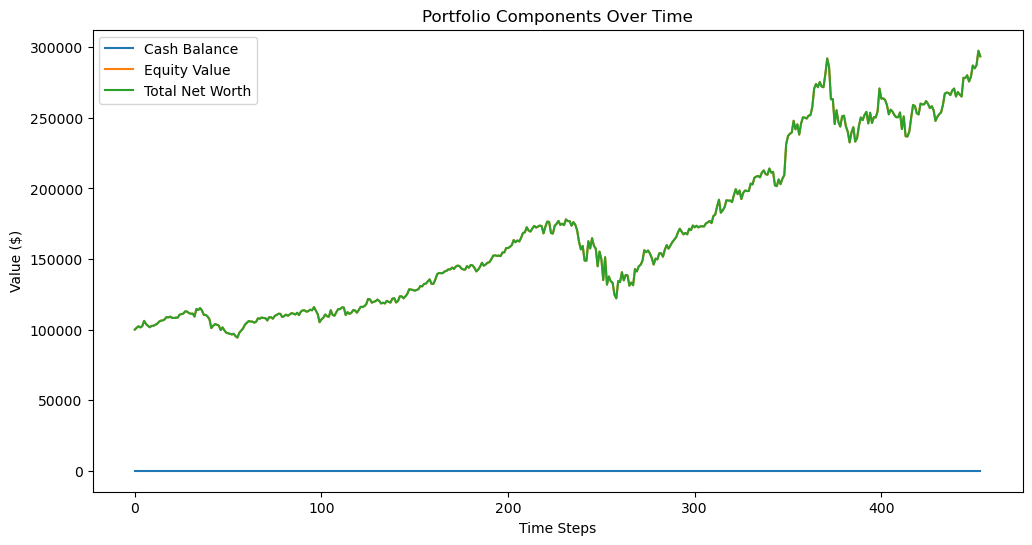


Training DQN agent for TSLA
Episode 1/100, Total Reward: 184548227.57794344, Epsilon: 0.01
Episode 2/100, Total Reward: 627811025.536526, Epsilon: 0.01
Episode 3/100, Total Reward: 216824347.59194136, Epsilon: 0.01
Episode 4/100, Total Reward: 49152850.69156098, Epsilon: 0.01
Episode 5/100, Total Reward: 702180206.2913091, Epsilon: 0.01
Episode 6/100, Total Reward: 168233216.71765423, Epsilon: 0.01
Episode 7/100, Total Reward: 165232666.6405772, Epsilon: 0.01
Episode 8/100, Total Reward: 249430897.54210865, Epsilon: 0.01
Episode 9/100, Total Reward: 542733920.838766, Epsilon: 0.01
Episode 10/100, Total Reward: 94864402.15069973, Epsilon: 0.01
Episode 11/100, Total Reward: 97408251.18504965, Epsilon: 0.01
Episode 12/100, Total Reward: 161454238.583066, Epsilon: 0.01
Episode 13/100, Total Reward: 318497699.52605736, Epsilon: 0.01
Episode 14/100, Total Reward: 228803104.24014843, Epsilon: 0.01
Episode 15/100, Total Reward: 625712771.8257134, Epsilon: 0.01
Episode 16/100, Total Reward: 57

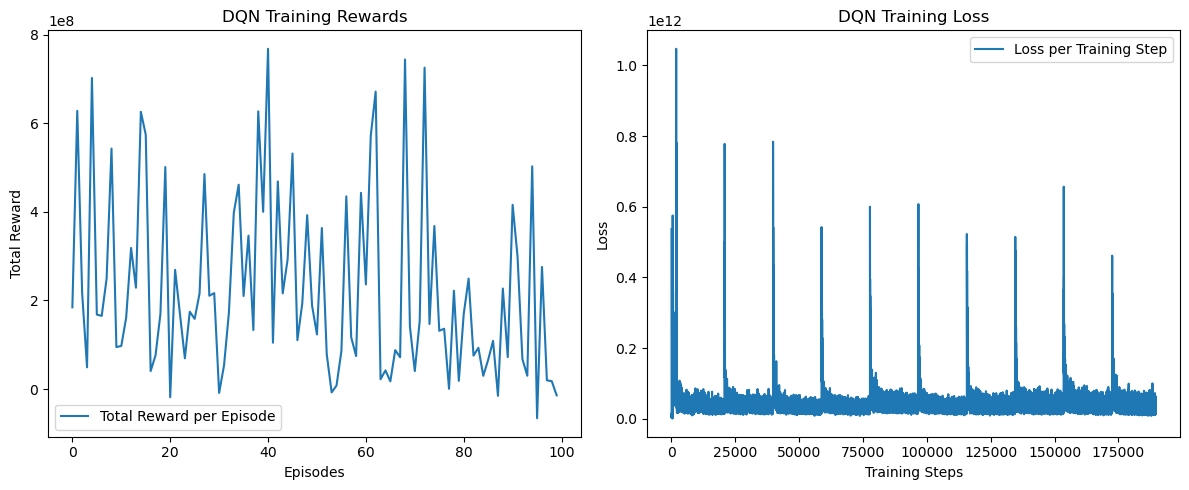

Test completed. Total Reward: 0.0


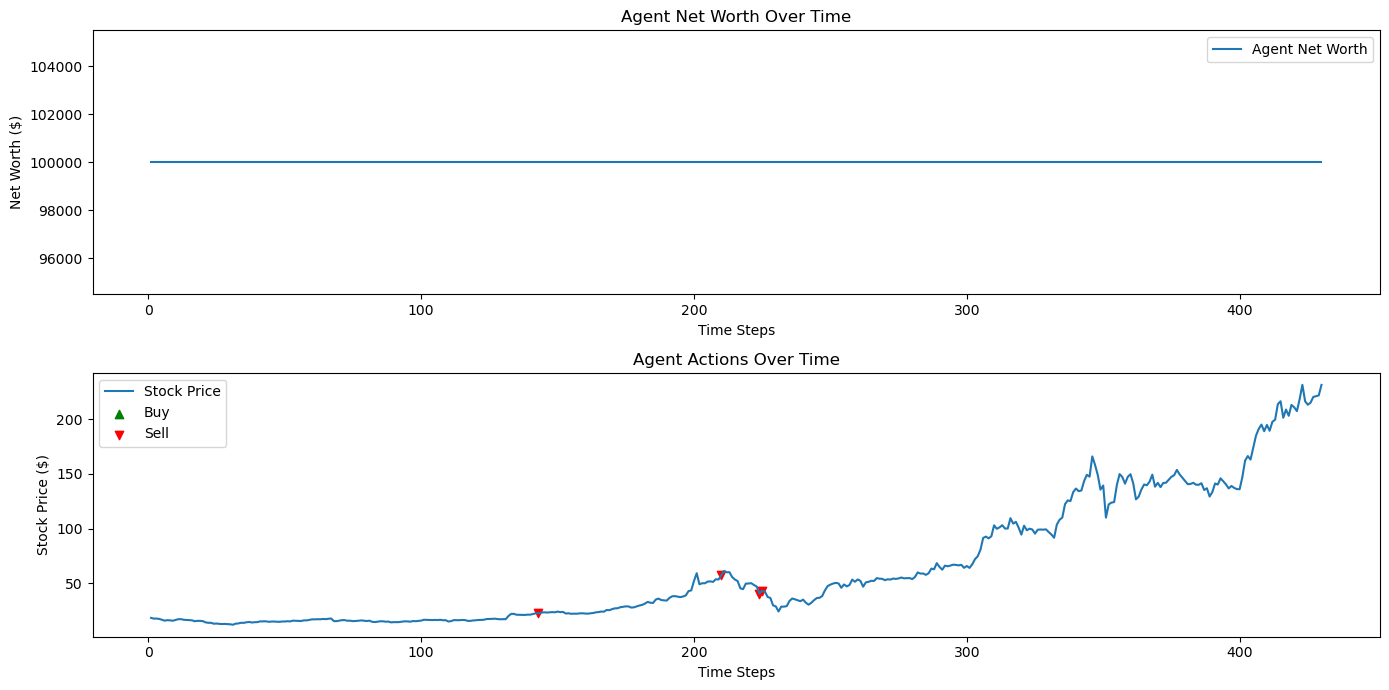

Total Return: 0.00%
Annualized Return: 0.00%
Sharpe Ratio: nan
Maximum Drawdown: 0.00%


C:\Users\yang1\AppData\Local\Temp\ipykernel_31716\2866169324.py:8: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = (np.mean(returns) - risk_free_rate) / np.std(returns) * np.sqrt(252)


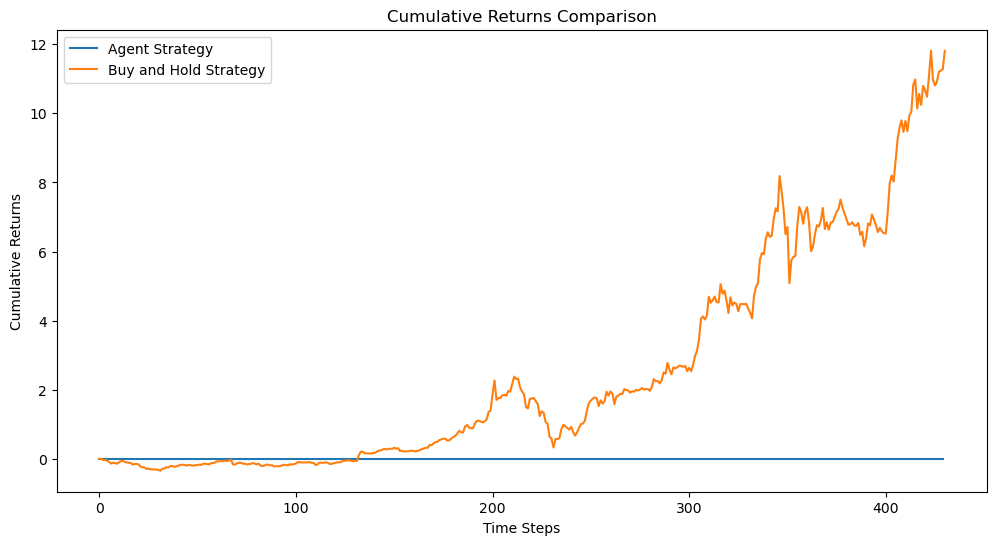

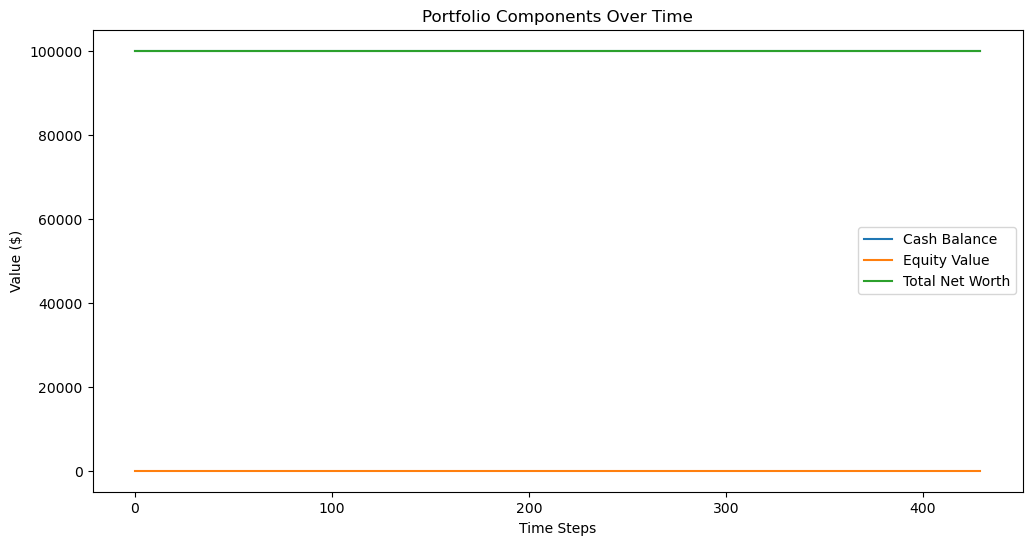


Training DQN agent for AMZN
Episode 1/100, Total Reward: 146322416.08653927, Epsilon: 0.01
Episode 2/100, Total Reward: 18925077.010928154, Epsilon: 0.01
Episode 3/100, Total Reward: 55175794.93021107, Epsilon: 0.01
Episode 4/100, Total Reward: 108046120.58749485, Epsilon: 0.01
Episode 5/100, Total Reward: -28510476.92442894, Epsilon: 0.01
Episode 6/100, Total Reward: 147516550.03264523, Epsilon: 0.01
Episode 7/100, Total Reward: 186673279.8366623, Epsilon: 0.01
Episode 8/100, Total Reward: 140498752.72135925, Epsilon: 0.01
Episode 9/100, Total Reward: 134724474.1875534, Epsilon: 0.01
Episode 10/100, Total Reward: -9397656.498947144, Epsilon: 0.01
Episode 11/100, Total Reward: 176033804.46051788, Epsilon: 0.01
Episode 12/100, Total Reward: 155720612.31415558, Epsilon: 0.01
Episode 13/100, Total Reward: 129861692.96177769, Epsilon: 0.01
Episode 14/100, Total Reward: 228973010.3839426, Epsilon: 0.01
Episode 15/100, Total Reward: 28032837.982927322, Epsilon: 0.01
Episode 16/100, Total Re

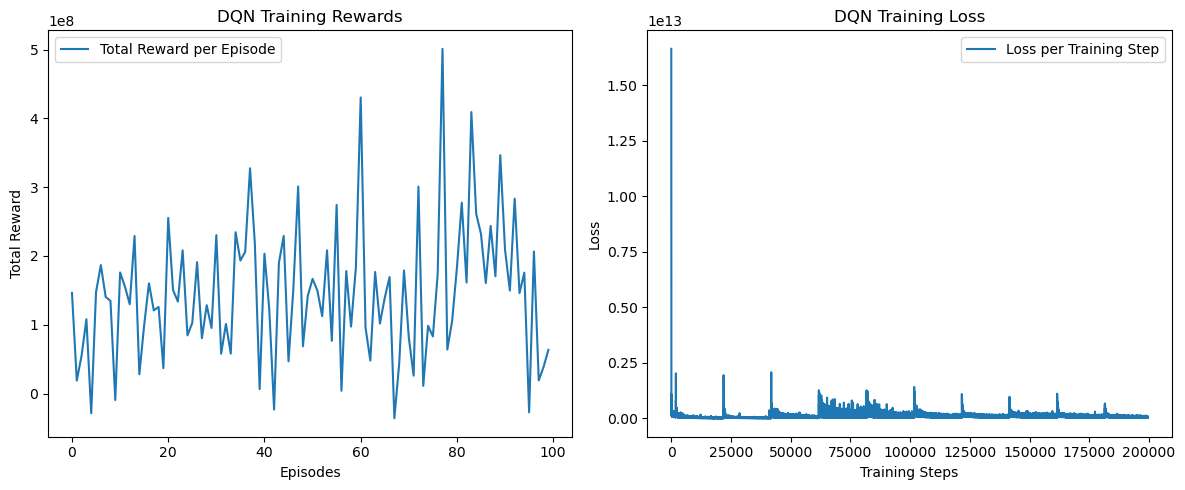

Test completed. Total Reward: 16658524.071044922


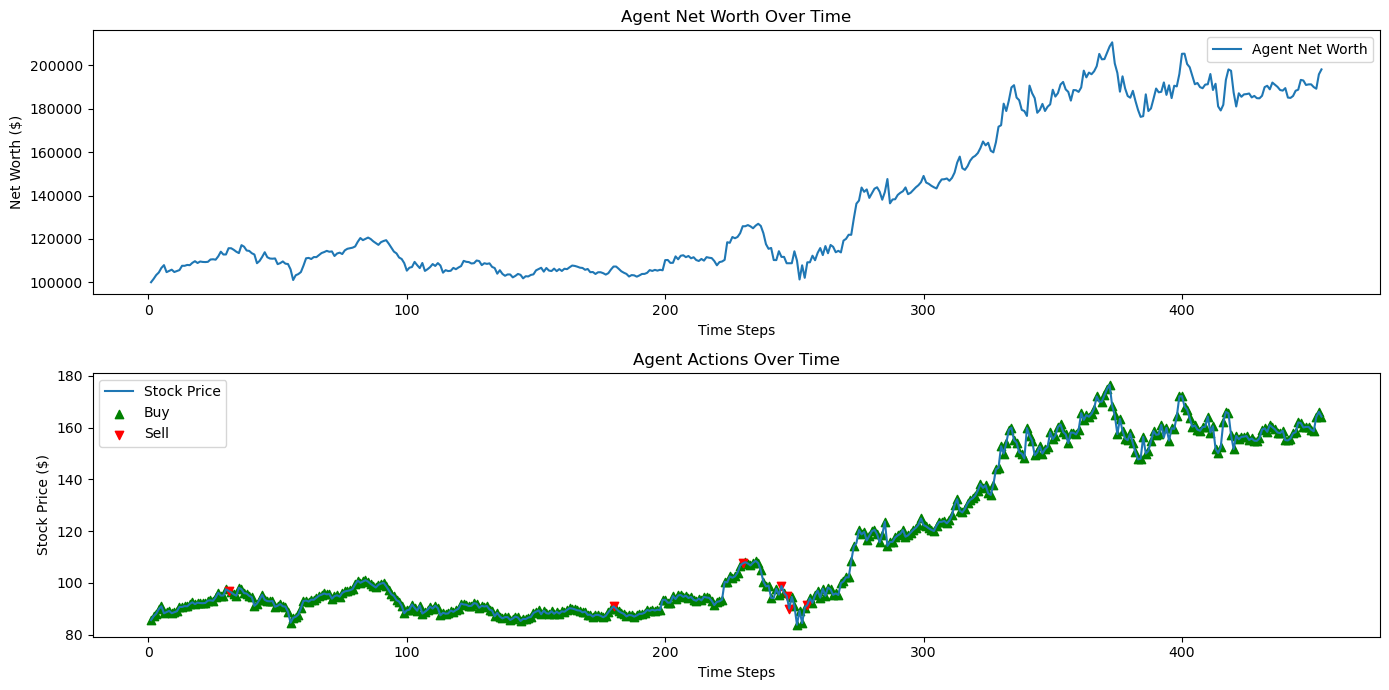

Total Return: 98.19%
Annualized Return: 54.50%
Sharpe Ratio: 1.37
Maximum Drawdown: 34.39%


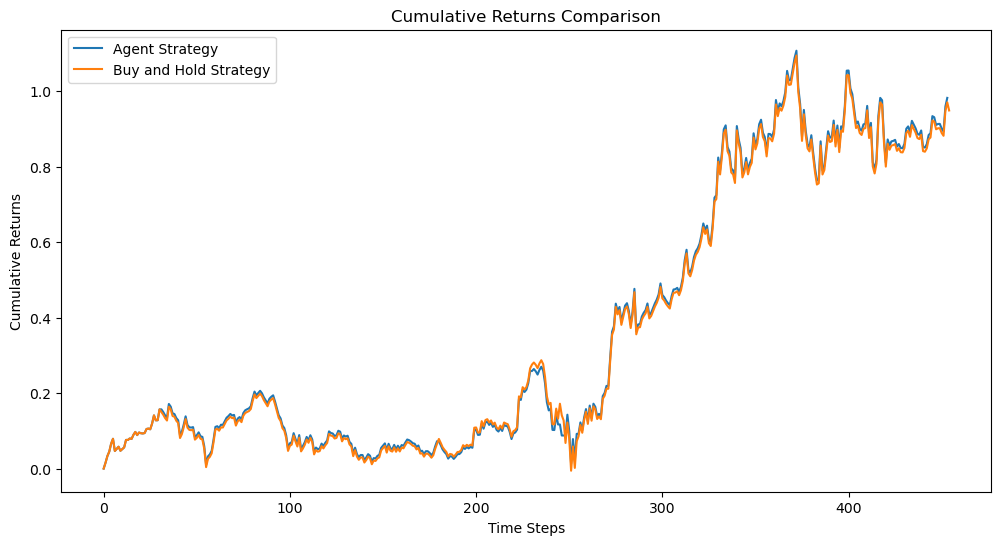

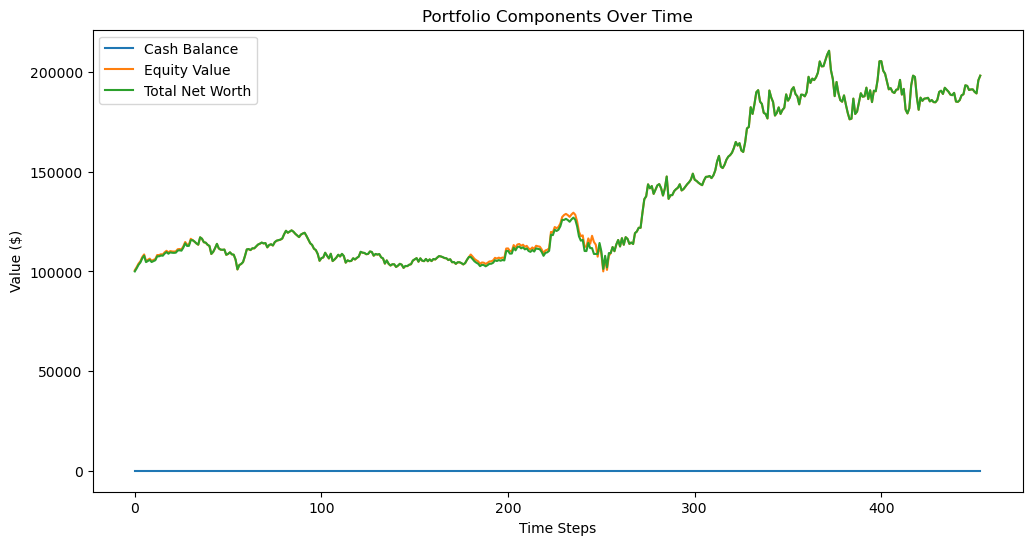


Training DQN agent for GOOGL
Episode 1/100, Total Reward: 49751628.588127136, Epsilon: 0.01
Episode 2/100, Total Reward: 30207436.50168705, Epsilon: 0.01
Episode 3/100, Total Reward: 2312169.3327770233, Epsilon: 0.01
Episode 4/100, Total Reward: 6662263.576506615, Epsilon: 0.01
Episode 5/100, Total Reward: 19255468.135038376, Epsilon: 0.01
Episode 6/100, Total Reward: 160844556.80186749, Epsilon: 0.01
Episode 7/100, Total Reward: 117452996.73027039, Epsilon: 0.01
Episode 8/100, Total Reward: 16321763.027900696, Epsilon: 0.01
Episode 9/100, Total Reward: 29946849.628109932, Epsilon: 0.01
Episode 10/100, Total Reward: 48271641.92155266, Epsilon: 0.01
Episode 11/100, Total Reward: 95126900.37099934, Epsilon: 0.01
Episode 12/100, Total Reward: 88667034.69863892, Epsilon: 0.01
Episode 13/100, Total Reward: 18319779.321044922, Epsilon: 0.01
Episode 14/100, Total Reward: 74375271.542943, Epsilon: 0.01
Episode 15/100, Total Reward: 12738104.359567642, Epsilon: 0.01
Episode 16/100, Total Rewar

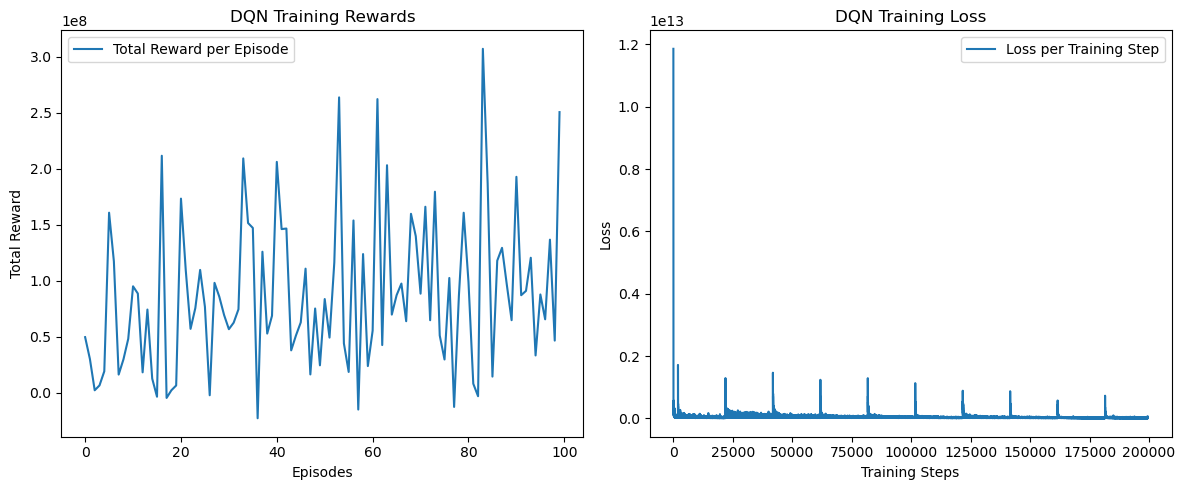

Test completed. Total Reward: 7480027.801483154


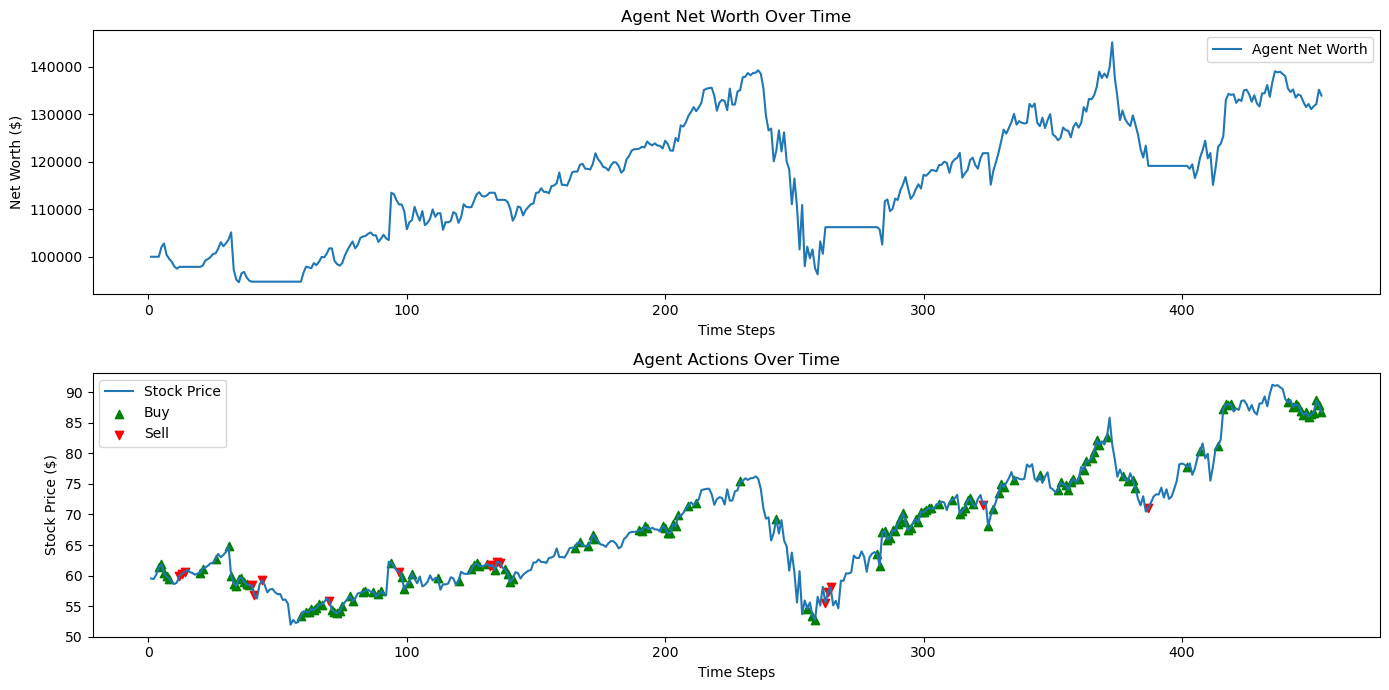

Total Return: 33.95%
Annualized Return: 18.84%
Sharpe Ratio: 0.70
Maximum Drawdown: 42.98%


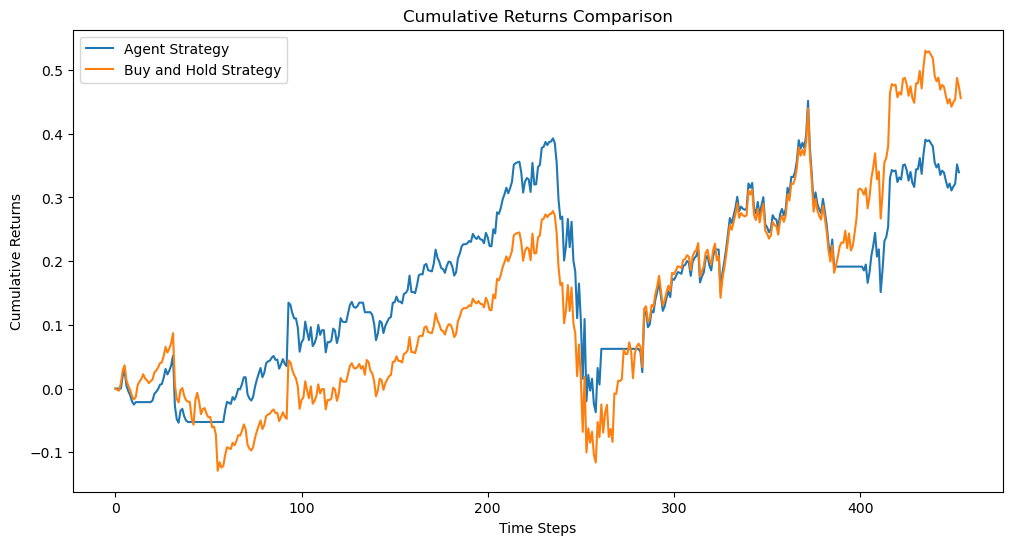

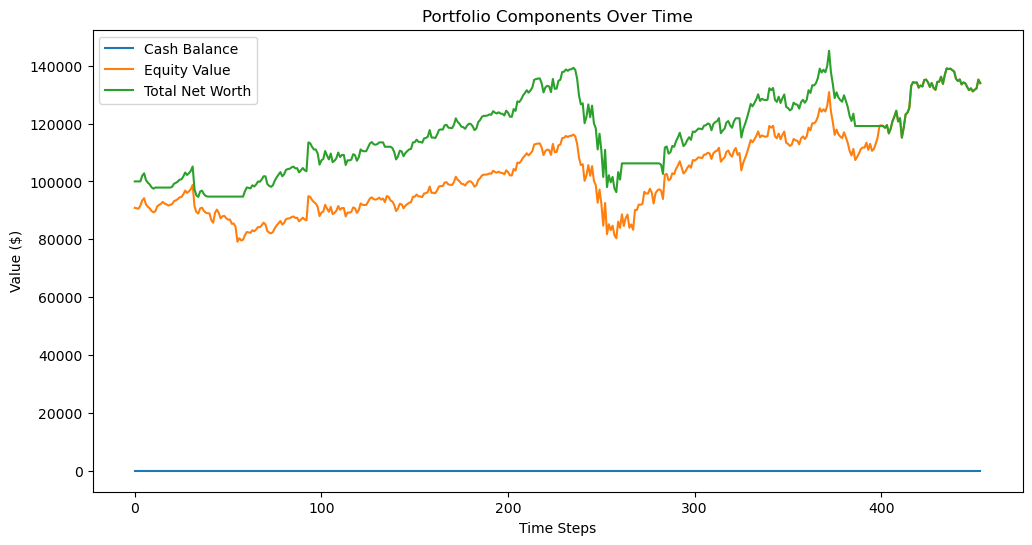


Training DQN agent for MSFT
Episode 1/100, Total Reward: 68095227.09372902, Epsilon: 0.01
Episode 2/100, Total Reward: 55974160.407958984, Epsilon: 0.01
Episode 3/100, Total Reward: 203135264.36152077, Epsilon: 0.01
Episode 4/100, Total Reward: 98001090.73135376, Epsilon: 0.01
Episode 5/100, Total Reward: 158881546.18107414, Epsilon: 0.01
Episode 6/100, Total Reward: 137885845.73207283, Epsilon: 0.01
Episode 7/100, Total Reward: 47018338.04381561, Epsilon: 0.01
Episode 8/100, Total Reward: 165993197.07460594, Epsilon: 0.01
Episode 9/100, Total Reward: 92907542.82841301, Epsilon: 0.01
Episode 10/100, Total Reward: 19678096.45673752, Epsilon: 0.01
Episode 11/100, Total Reward: 54774870.78156471, Epsilon: 0.01
Episode 12/100, Total Reward: 59047663.803424835, Epsilon: 0.01
Episode 13/100, Total Reward: 14618544.89192772, Epsilon: 0.01
Episode 14/100, Total Reward: 177603357.75687218, Epsilon: 0.01
Episode 15/100, Total Reward: 51299737.62772751, Epsilon: 0.01
Episode 16/100, Total Reward

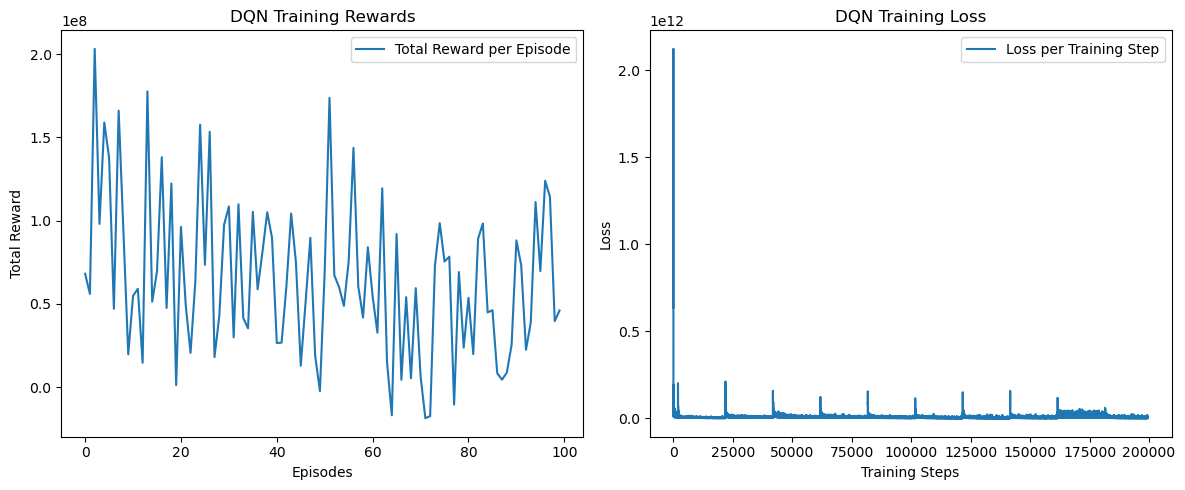

Test completed. Total Reward: 20907387.4107666


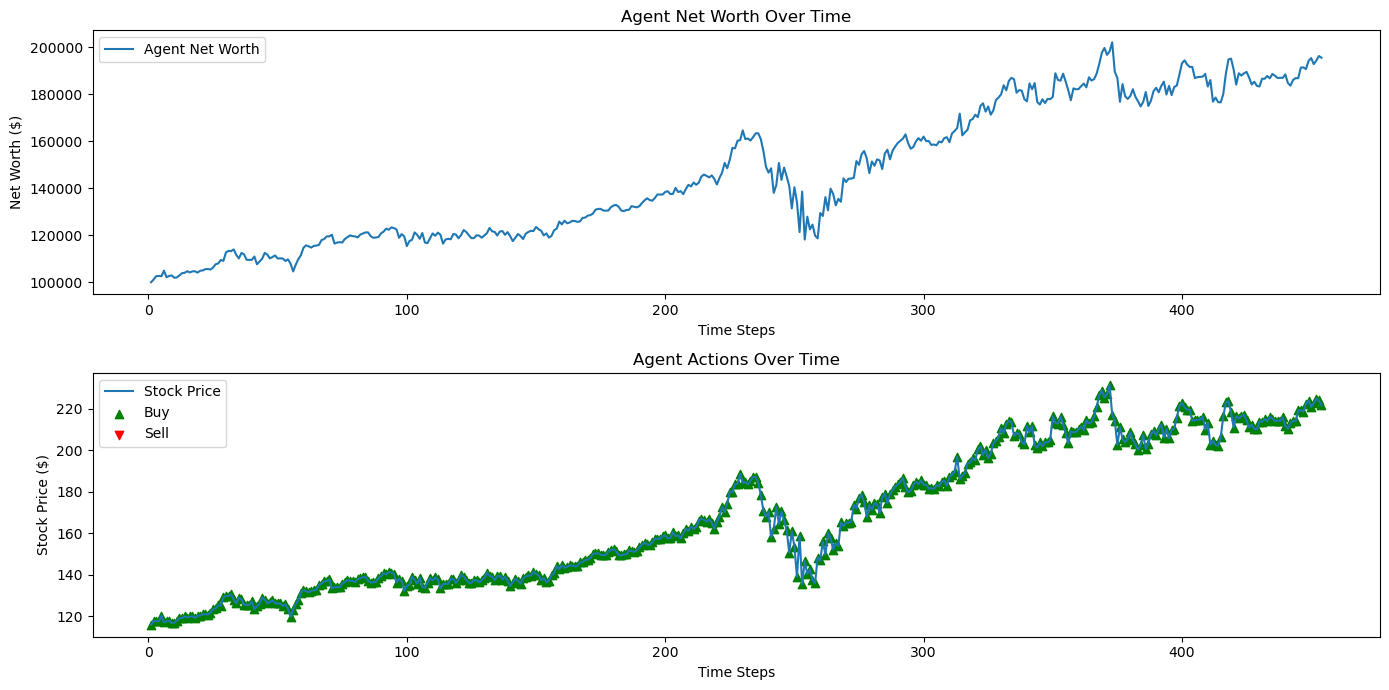

Total Return: 95.54%
Annualized Return: 53.03%
Sharpe Ratio: 1.24
Maximum Drawdown: 46.46%


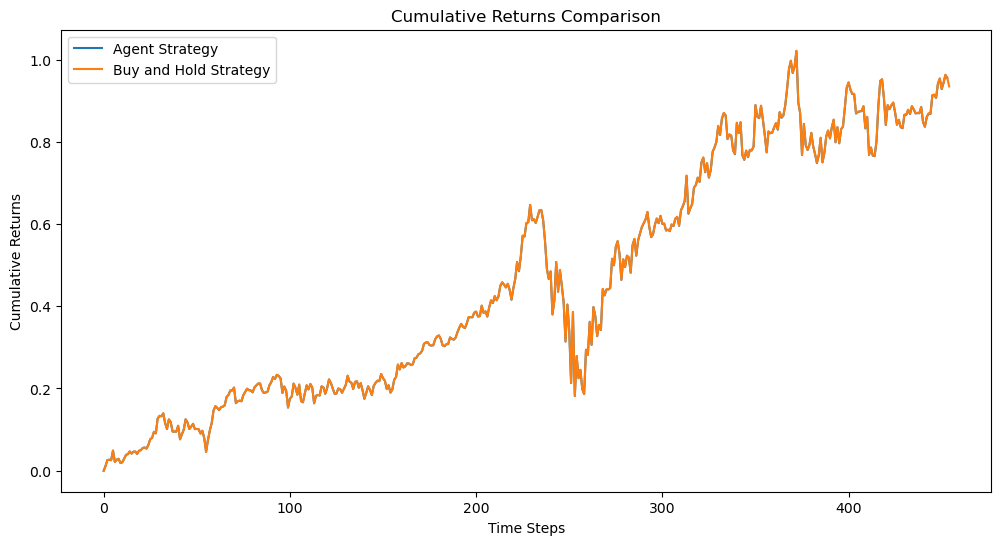

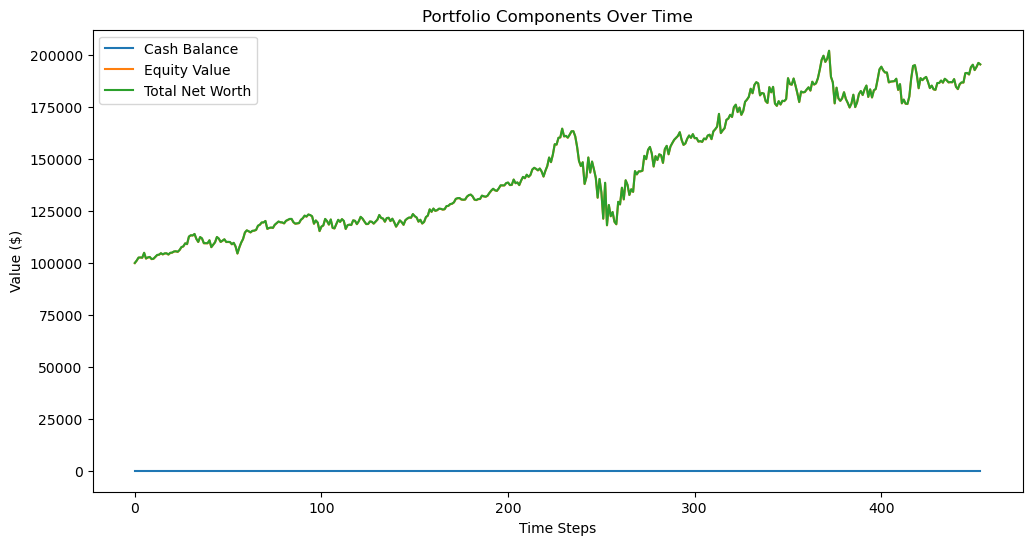


Training DQN agent for META
Episode 1/100, Total Reward: 219349425.96252823, Epsilon: 0.01
Episode 2/100, Total Reward: 179752132.10100174, Epsilon: 0.01
Episode 3/100, Total Reward: 158283712.37246704, Epsilon: 0.01
Episode 4/100, Total Reward: 155267342.03092957, Epsilon: 0.01
Episode 5/100, Total Reward: 124137685.56804085, Epsilon: 0.01
Episode 6/100, Total Reward: 146091628.95736694, Epsilon: 0.01
Episode 7/100, Total Reward: 285835568.00831604, Epsilon: 0.01
Episode 8/100, Total Reward: 162100237.0974865, Epsilon: 0.01
Episode 9/100, Total Reward: 141355509.83781052, Epsilon: 0.01
Episode 10/100, Total Reward: 263101781.63275528, Epsilon: 0.01
Episode 11/100, Total Reward: 268552721.0750637, Epsilon: 0.01
Episode 12/100, Total Reward: 221402422.21963882, Epsilon: 0.01
Episode 13/100, Total Reward: 85097645.77445221, Epsilon: 0.01
Episode 14/100, Total Reward: 185522462.8425789, Epsilon: 0.01
Episode 15/100, Total Reward: 242777968.0814438, Epsilon: 0.01
Episode 16/100, Total Rew

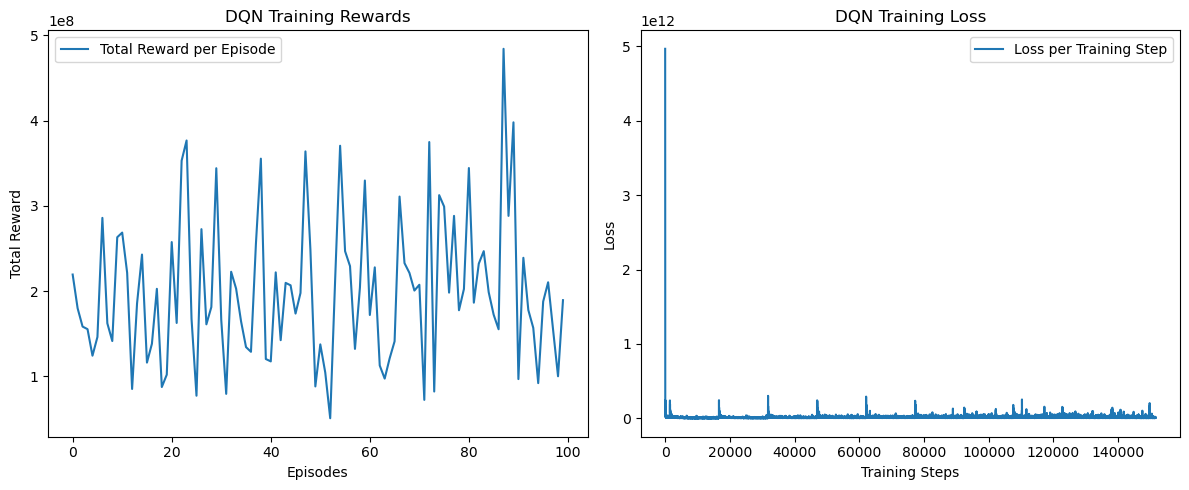

Test completed. Total Reward: 0.0


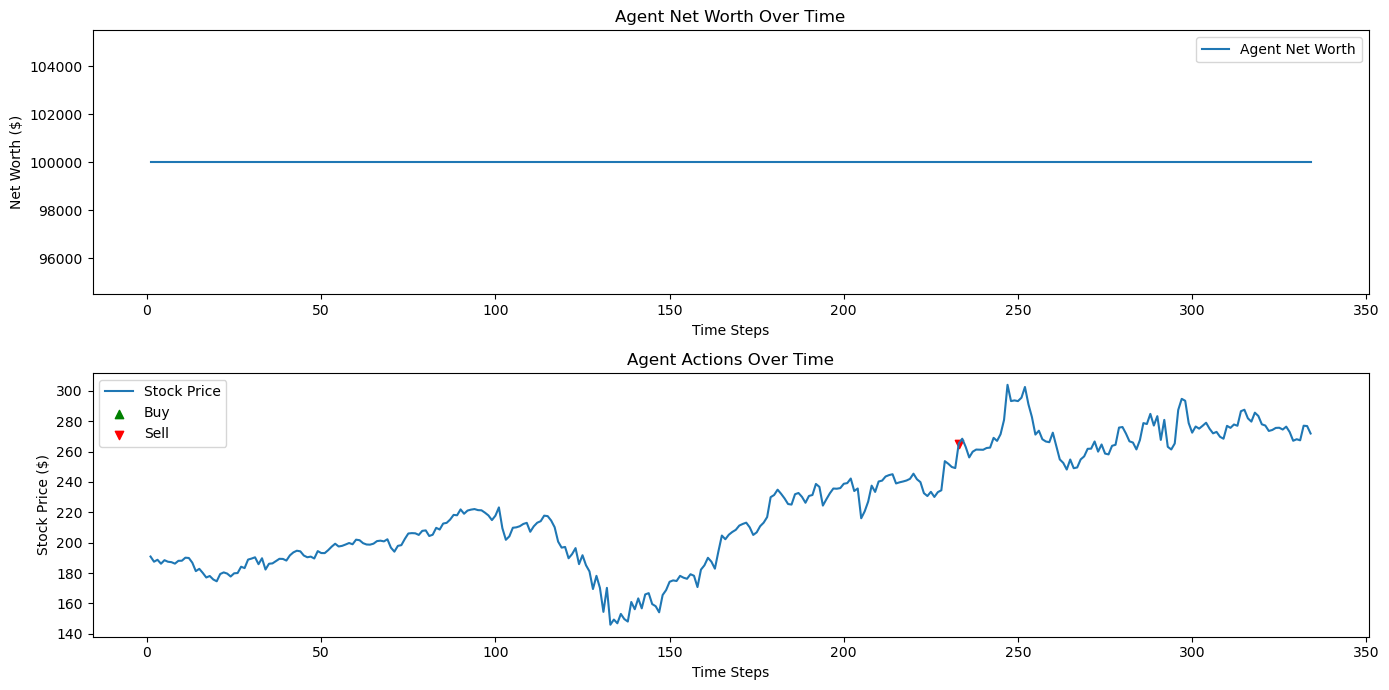

Total Return: 0.00%
Annualized Return: 0.00%
Sharpe Ratio: nan
Maximum Drawdown: 0.00%


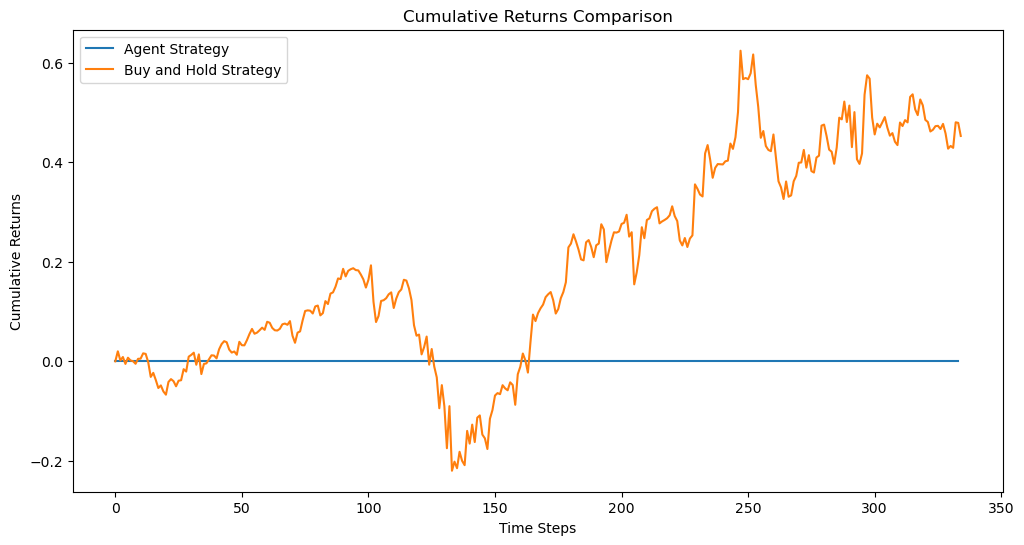

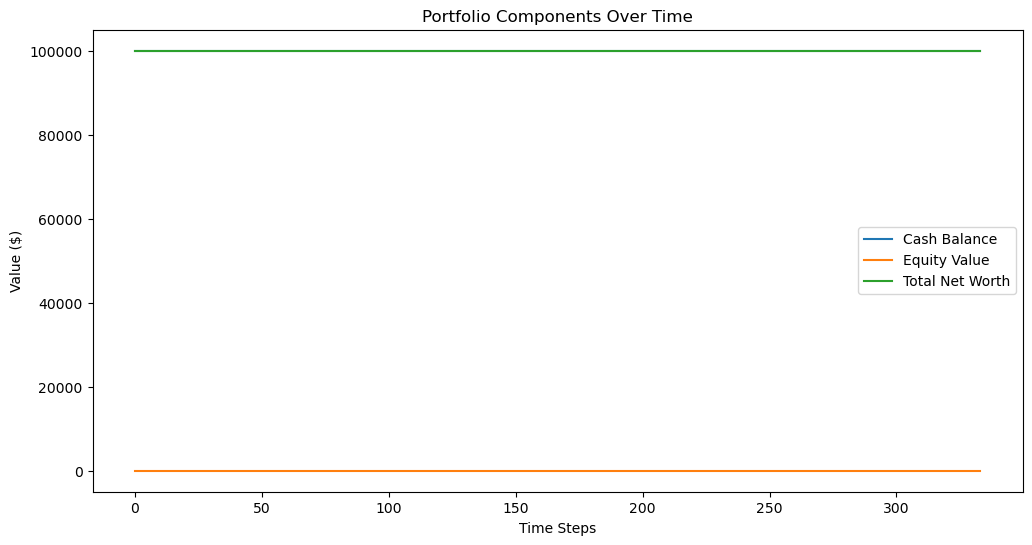


Training DQN agent for NVDA
Episode 1/100, Total Reward: 142691534.75661668, Epsilon: 0.01
Episode 2/100, Total Reward: 362788598.79659235, Epsilon: 0.01
Episode 3/100, Total Reward: 288190986.39728653, Epsilon: 0.01
Episode 4/100, Total Reward: 22788488.042130858, Epsilon: 0.01
Episode 5/100, Total Reward: -20265181.541886, Epsilon: 0.01
Episode 6/100, Total Reward: -77673754.84729108, Epsilon: 0.01
Episode 7/100, Total Reward: -105038026.15528014, Epsilon: 0.01
Episode 8/100, Total Reward: -16777549.062154055, Epsilon: 0.01
Episode 9/100, Total Reward: 93587810.7101349, Epsilon: 0.01
Episode 10/100, Total Reward: 238184193.33654478, Epsilon: 0.01
Episode 11/100, Total Reward: 97478747.11286038, Epsilon: 0.01
Episode 12/100, Total Reward: 30447654.10692185, Epsilon: 0.01
Episode 13/100, Total Reward: 33661367.17259458, Epsilon: 0.01
Episode 14/100, Total Reward: 113048883.3941108, Epsilon: 0.01
Episode 15/100, Total Reward: -6702883.93691355, Epsilon: 0.01
Episode 16/100, Total Rewar

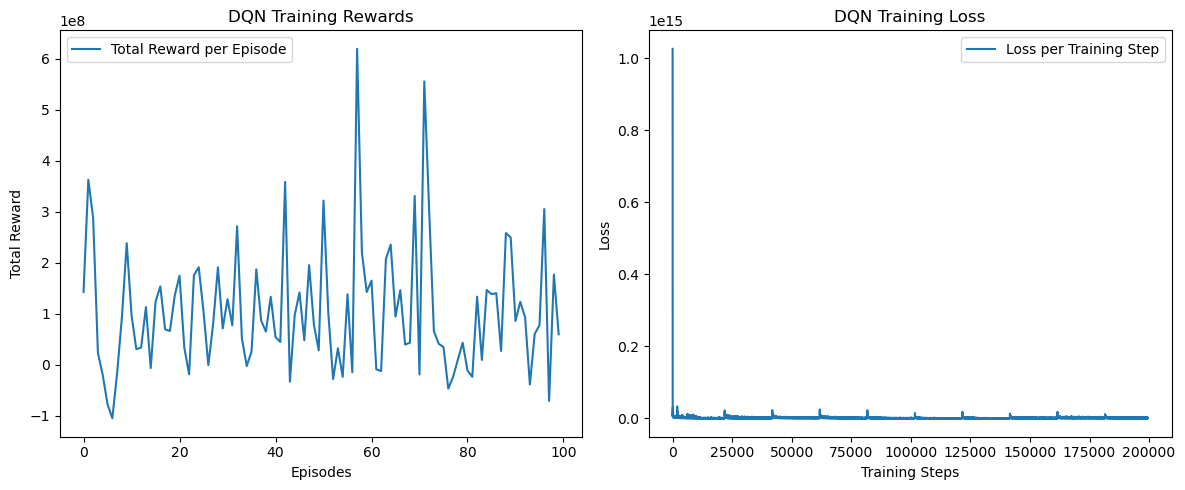

Test completed. Total Reward: 36547146.795692444


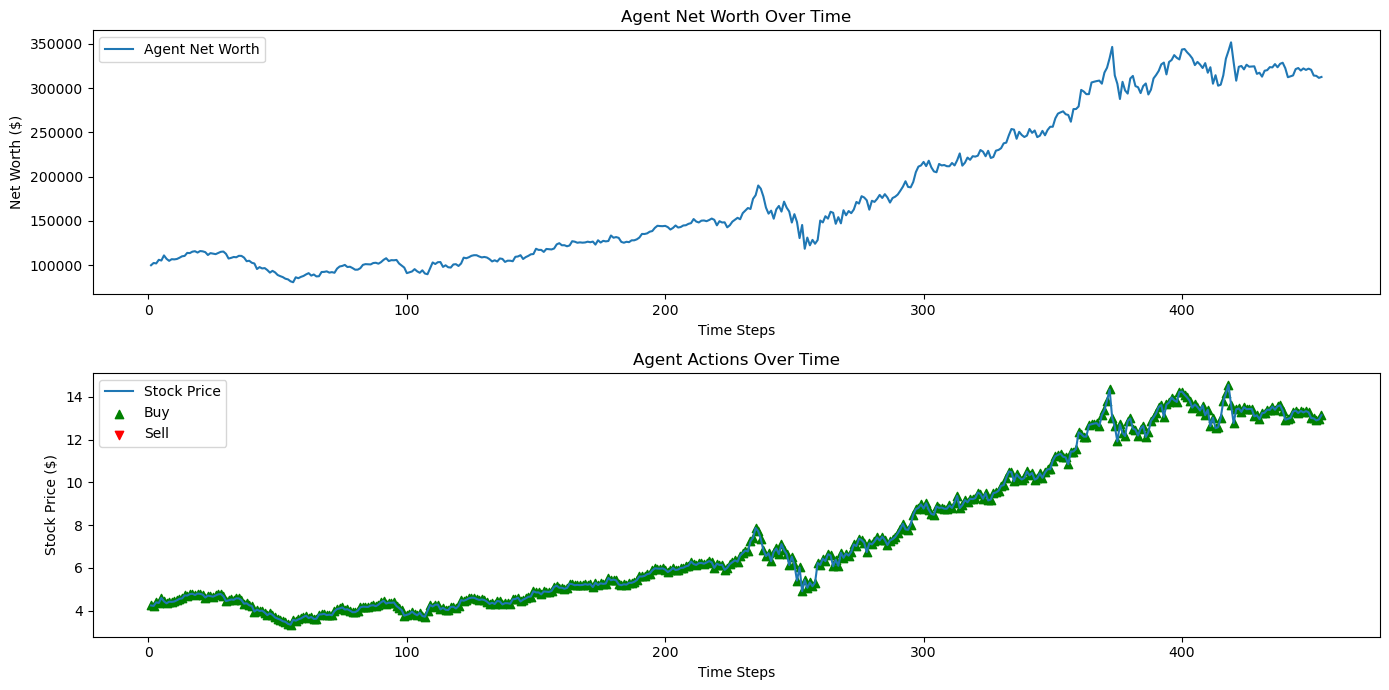

Total Return: 212.71%
Annualized Return: 118.07%
Sharpe Ratio: 1.53
Maximum Drawdown: 71.45%


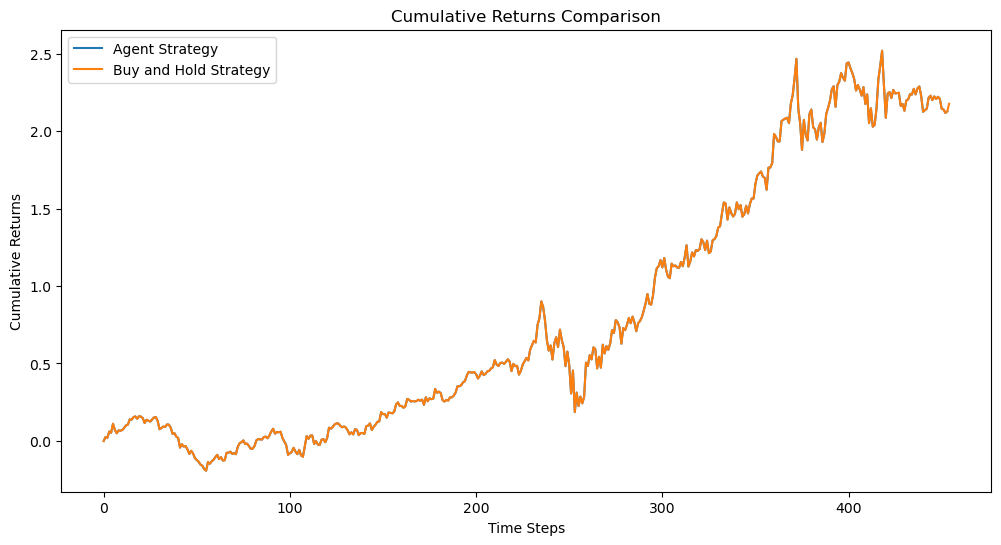

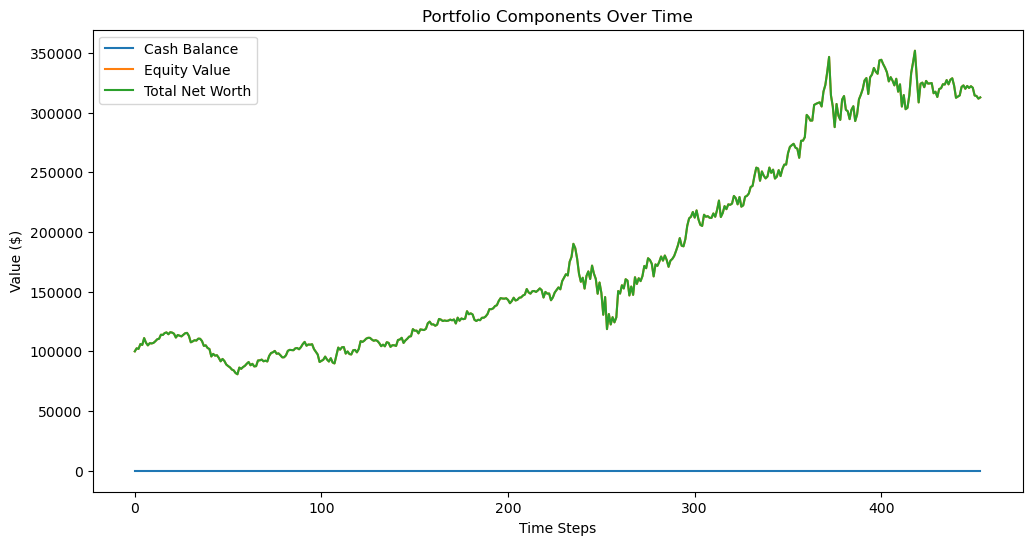

In [ ]:
if __name__ == "__main__":
    num_episodes = 100  # Adjust as needed
    batch_size = 64
    target_update_freq = 10

    for ticker in STOCKS:
        print(f"\nTraining DQN agent for {ticker}")
        # Prepare environment
        df_train = train_data[ticker]
        env = TradingEnv(df_train)

        # Determine state and action sizes
        state_size = env.observation_space.shape[0] * env.observation_space.shape[1]
        action_size = env.action_space.n

        # Initialize agent
        agent = DQNAgent(state_size=state_size, action_size=action_size, device='cpu')

        # Train agent
        rewards_history, losses = train_dqn_agent(env, agent, num_episodes=num_episodes, batch_size=batch_size, target_update_freq=target_update_freq)

        # Save the trained model
        torch.save(agent.q_network.state_dict(), f'dqn_trading_agent_{ticker}.pt')
        print(f"Trained DQN agent for {ticker} saved as dqn_trading_agent_{ticker}.pt")

        # Plot training metrics
        plot_training_metrics(rewards_history, losses)

        # Testing the agent on test data
        df_test = test_data[ticker]
        env_test = TradingEnv(df_test)
        agent.q_network.eval()
        net_worths, actions, prices, steps = test_dqn_agent(env_test, agent)

        # Plot test performance
        plot_test_performance(net_worths, actions, prices, steps)
        compute_performance_metrics(net_worths)
        plot_cumulative_returns(net_worths, env_test)
        plot_portfolio_components(env_test, net_worths)


In [ ]:
# Assuming you have already split your data into train_data and test_data
# If not, here's how you can do it:

TRAIN_TEST_SPLIT = 0.8  # 80% training, 20% testing

for ticker in STOCKS:
    df = data[ticker]
    split_idx = int(len(df) * TRAIN_TEST_SPLIT)
    train_data[ticker] = df[:split_idx]
    test_data[ticker] = df[split_idx:]


NameError: name 'train_data' is not defined

In [ ]:
def test_dqn_agent(env, agent):
    state = env.reset()
    done = False
    total_reward = 0
    agent.epsilon = 0.0  # No exploration during testing
    net_worths = []
    actions = []
    prices = []
    steps = []
    
    while not done:
        state_flat = state.flatten()
        action = agent.act(state_flat)
        next_state, reward, done, _ = env.step(action)
        
        # Record data
        net_worths.append(env.net_worth)
        actions.append(action)
        current_price = float(env.df.iloc[env.current_step + env.window_size - 1]['Close'])
        prices.append(current_price)
        steps.append(env.current_step)
        
        state = next_state
        total_reward += reward
    
    print(f"Test completed. Total Reward: {total_reward}")
    return net_worths, actions, prices, steps

In [ ]:
def plot_cumulative_returns(net_worths, env):
    initial_balance = env.initial_balance
    agent_returns = np.array(net_worths) / initial_balance - 1
    # Buy-and-hold returns
    initial_price = float(env.df.iloc[env.window_size - 1]['Close'])
    final_price = env.df['Close'].values[env.window_size - 1:]
    buy_and_hold_returns = final_price / initial_price - 1
    
    plt.figure(figsize=(12,6))
    plt.plot(agent_returns, label='Agent Strategy')
    plt.plot(buy_and_hold_returns, label='Buy and Hold Strategy')
    plt.xlabel('Time Steps')
    plt.ylabel('Cumulative Returns')
    plt.title('Cumulative Returns Comparison')
    plt.legend()
    plt.show()


In [ ]:
def plot_portfolio_components(env, net_worths):
    cash_balances = []
    equity_values = []
    current_step = env.window_size
    for net_worth in net_worths:
        current_price = float(env.df.iloc[current_step - 1]['Close'])
        equity_value = env.shares_held * current_price
        cash_balance = env.balance
        cash_balances.append(cash_balance)
        equity_values.append(equity_value)
        current_step += 1
    
    plt.figure(figsize=(12,6))
    plt.plot(cash_balances, label='Cash Balance')
    plt.plot(equity_values, label='Equity Value')
    plt.plot(net_worths, label='Total Net Worth')
    plt.xlabel('Time Steps')
    plt.ylabel('Value ($)')
    plt.title('Portfolio Components Over Time')
    plt.legend()
    plt.show()


In [ ]:
def plot_test_performance(net_worths, actions, prices, steps):
    # Plot Net Worth Over Time
    plt.figure(figsize=(14,7))
    plt.subplot(2,1,1)
    plt.plot(steps, net_worths, label='Agent Net Worth')
    plt.xlabel('Time Steps')
    plt.ylabel('Net Worth ($)')
    plt.title('Agent Net Worth Over Time')
    plt.legend()
    
    # Plot Actions Over Time
    plt.subplot(2,1,2)
    plt.plot(steps, prices, label='Stock Price')
    buy_steps = [s for s, a in zip(steps, actions) if a == 1]
    sell_steps = [s for s, a in zip(steps, actions) if a == 2]
    hold_steps = [s for s, a in zip(steps, actions) if a == 0]
    plt.scatter(buy_steps, [prices[s - steps[0]] for s in buy_steps], marker='^', color='g', label='Buy')
    plt.scatter(sell_steps, [prices[s - steps[0]] for s in sell_steps], marker='v', color='r', label='Sell')
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price ($)')
    plt.title('Agent Actions Over Time')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
def compute_buy_and_hold(env):
    initial_balance = env.initial_balance
    initial_price = float(env.df.iloc[env.window_size - 1]['Close'])
    final_price = float(env.df.iloc[-1]['Close'])
    shares = initial_balance // initial_price
    remaining_balance = initial_balance - shares * initial_price
    final_net_worth = remaining_balance + shares * final_price
    return final_net_worth


In [ ]:
def compute_performance_metrics(net_worths):
    returns = np.diff(net_worths) / net_worths[:-1]
    total_return = (net_worths[-1] - net_worths[0]) / net_worths[0]
    annualized_return = total_return * (252 / len(net_worths))  # Assuming daily data
    
    # Sharpe Ratio
    risk_free_rate = 0.0  # Assuming zero risk-free rate
    sharpe_ratio = (np.mean(returns) - risk_free_rate) / np.std(returns) * np.sqrt(252)
    
    # Maximum Drawdown
    cumulative_returns = np.array(net_worths) / net_worths[0]
    running_max = np.maximum.accumulate(cumulative_returns)
    drawdowns = running_max - cumulative_returns
    max_drawdown = np.max(drawdowns)
    
    print(f"Total Return: {total_return * 100:.2f}%")
    print(f"Annualized Return: {annualized_return * 100:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")

In [ ]:
if __name__ == "__main__":
    # Load the test data
    ticker = 'AAPL'
    df_test = test_data[ticker]
    env_test = TradingEnv(df_test)
    
    # Initialize agent
    state_size = env_test.observation_space.shape[0] * env_test.observation_space.shape[1]
    action_size = env_test.action_space.n
    
    agent = DQNAgent(state_size=state_size, action_size=action_size, device='cpu')
    # Load the trained model
    agent.q_network.load_state_dict(torch.load(f'dqn_trading_agent_{ticker}.pt'))
    agent.q_network.eval()
    
    # Test the agent
    net_worths, actions, prices, steps = test_dqn_agent(env_test, agent)
    
    # Plot the performance
    plot_test_performance(net_worths, actions, prices, steps)
    
    # Compute performance metrics
    compute_performance_metrics(net_worths)
    
    # Compute buy-and-hold net worth
    buy_and_hold_net_worth = compute_buy_and_hold(env_test)
    print(f"Buy and Hold Net Worth: ${buy_and_hold_net_worth:.2f}")
    print(f"Agent's Final Net Worth: ${net_worths[-1]:.2f}")

NameError: name 'test_data' is not defined